# Hybrid Derivative Pricing: Heston-Hull-White Model

## Product Overview

This notebook prices a hybrid financial derivative that combines equity and interest rate risk. The contract pays at settlement ($T+\Delta$):

$$\text{Payoff} = N \cdot \max\left[0, \left(k - \frac{S(T)}{S(0)}\right) \cdot \left(\frac{L(T,T,T+\Delta)}{L(0,T,T+\Delta)} - k^{\prime}\right)\right]$$

Where:
- $S(t)$ is the equity spot (SX5E) in USD (Quanto)
- $L(T, T, T+\Delta)$ is the n-month USD Libor/Forward rate observed at time $T$
- $N$ is the notional
- $T$ is the maturity
- $\Delta$ is the tenor
- Settlement occurs at $T + \Delta$


## Model Specifications

### A. Equity: Heston Stochastic Volatility Model (with Quanto Adjustment)

The equity price follows a Heston model with quanto drift adjustment:

$$dS_t = (r_t - q - \text{quanto\_adj}) S_t dt + \sqrt{v_t} S_t dW_S$$

The variance process follows a mean-reverting square-root process:

$$dv_t = \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_v$$

Where:
- $S_t$: Equity spot price
- $v_t$: Variance process
- $r_t$: Stochastic interest rate
- $q$: Dividend yield
- $\text{quanto\_adj}$: Quanto adjustment term
- $\kappa$: Mean reversion speed
- $\theta$: Long-term variance
- $\xi$: Volatility of volatility
- $dW_S, dW_v$: Correlated Brownian motions

**Discretization Scheme:** We use the **Full Truncation** scheme for the variance process to ensure non-negativity:
- $v_{t+\Delta t} = \max(0, v_t + \kappa(\theta - v_t^+) \Delta t + \xi \sqrt{v_t^+} \Delta W_v)$
- Where $v_t^+ = \max(0, v_t)$

### B. Interest Rates: Hull-White One-Factor Model

The short rate follows:

$$dr_t = (\theta(t) - a r_t) dt + \sigma_r dW_r$$

Where:
- $a$: Mean reversion speed
- $\sigma_r$: Volatility of the short rate
- $\theta(t)$: Time-dependent drift (calibrated to fit initial yield curve)

**Bond Pricing:** The Hull-White model has a closed-form solution for zero-coupon bond prices:

$$P(T, S) = A(T,S) e^{-B(T,S) r(T)}$$

Where:
- $B(T,S) = \frac{1 - e^{-a(S-T)}}{a}$
- $A(T,S) = \exp\left(\frac{1}{2}\left[\frac{\sigma_r^2}{a^2}(S-T) - \frac{\sigma_r^2}{a^3}(1-e^{-a(S-T)})(1-e^{-2aT})\right] - \frac{\sigma_r^2}{4a^3}(1-e^{-a(S-T)})^2(1-e^{-2aT})\right)$

The forward rate $L(T, T, T+\Delta)$ is calculated as:

$$L(T, T, T+\Delta) = \frac{1}{\Delta}\left(\frac{1}{P(T, T+\Delta)} - 1\right)$$

### C. Correlation Structure

The three Brownian motions are correlated:
- $\rho_{Sv}$: Correlation between equity and volatility (leverage effect, typically negative)
- $\rho_{Sr}$: Correlation between equity and rates (hybrid correlation)
- $\rho_{vr}$: Correlation between volatility and rates

We use Cholesky decomposition to generate correlated random numbers.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [14]:
@dataclass
class ModelParameters:
    """
    Configuration class for the Hybrid Heston-Hull-White model parameters.
    """
    # Equity parameters
    S0: float = 100.0          # Initial equity spot
    v0: float = 0.04           # Initial variance
    kappa: float = 2.0         # Mean reversion speed for variance
    theta: float = 0.04        # Long-term variance
    xi: float = 0.3           # Volatility of volatility
    q: float = 0.0            # Dividend yield
    quanto_adj: float = 0.0    # Quanto adjustment
    
    # Interest rate parameters
    r0: float = 0.03          # Initial short rate (flat curve)
    a: float = 0.05           # Mean reversion speed for rates
    sigma_r: float = 0.01     # Volatility of short rate
    
    # Correlations
    rho_Sv: float = -0.7      # Equity-Volatility correlation (leverage)
    rho_Sr: float = 0.3       # Equity-Rates correlation
    rho_vr: float = 0.0       # Volatility-Rates correlation
    
    # Product parameters
    T: float = 1.0            # Maturity (years)
    Delta: float = 0.25        # Tenor (years)
    k: float = 1.0            # Strike parameter
    k_prime: float = 1.0      # Rate strike parameter
    N: float = 1.0            # Notional
    
    # Simulation parameters
    M: int = 1000000            # Number of Monte Carlo paths
    n_steps: int = 12         # Number of time steps (monthly)
    
    def get_correlation_matrix(self) -> np.ndarray:
        """Construct the 3x3 correlation matrix."""
        corr = np.array([
            [1.0, self.rho_Sv, self.rho_Sr],
            [self.rho_Sv, 1.0, self.rho_vr],
            [self.rho_Sr, self.rho_vr, 1.0]
        ])
        return corr
    
    def get_cholesky(self) -> np.ndarray:
        """Compute Cholesky decomposition of correlation matrix."""
        corr = self.get_correlation_matrix()
        return np.linalg.cholesky(corr)


In [15]:
def hull_white_bond_price(r_t: np.ndarray, T: float, S: float, 
                          a: float, sigma_r: float, r0: float) -> np.ndarray:
    """
    Calculate Hull-White zero-coupon bond price P(T, S) using closed-form formula.
    Calibrated to a flat yield curve at r0.
    
    Parameters:
    -----------
    r_t : np.ndarray
        Short rate at time T (can be vectorized over paths)
    T : float
        Current time
    S : float
        Maturity time (S > T)
    a : float
        Mean reversion speed
    sigma_r : float
        Volatility of short rate
    r0 : float
        Initial short rate (for calibration to flat curve)
    
    Returns:
    --------
    np.ndarray
        Bond prices P(T, S) for each path
    """
    Delta = S - T
    
    # B(T, S) function
    B_TS = (1 - np.exp(-a * Delta)) / a
    
    # A(T, S) function calibrated to flat curve at r0
    # For flat curve: P(0,t) = exp(-r0*t), f(0,t) = r0
    # Standard Hull-White formula with flat curve calibration:
    # A(T,S) = P(0,S)/P(0,T) * exp(B(T,S)*f(0,T) - (sigma_r^2/(4*a))*(1-exp(-2*a*T))*B(T,S)^2)
    # For flat curve: P(0,S)/P(0,T) = exp(-r0*(S-T)), f(0,T) = r0
    
    # Variance term
    variance_term = (sigma_r**2 / (4 * a)) * (1 - np.exp(-2 * a * T)) * B_TS**2
    
    # A(T, S) with flat curve calibration
    A_TS = np.exp(-r0 * (S - T) + B_TS * r0 - variance_term)
    
    # Bond price formula: P(T, S) = A(T, S) * exp(-B(T, S) * r(T))
    P_TS = A_TS * np.exp(-B_TS * r_t)
    
    return P_TS


def calculate_forward_rate(r_T: np.ndarray, T: float, Delta: float,
                           a: float, sigma_r: float, r0: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate forward rate L(T, T, T+Delta) using Hull-White bond pricing.
    
    Parameters:
    -----------
    r_T : np.ndarray
        Short rate at time T (vectorized over paths)
    T : float
        Observation time
    Delta : float
        Tenor
    a : float
        Mean reversion speed
    sigma_r : float
        Volatility of short rate
    r0 : float
        Initial short rate
    
    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (L_T, L_0) - Forward rates at T and at t=0
    """
    # Forward rate at time T
    P_T_TplusDelta = hull_white_bond_price(r_T, T, T + Delta, a, sigma_r, r0)
    L_T = (1.0 / Delta) * ((1.0 / P_T_TplusDelta) - 1.0)
    
    # Forward rate at time 0 (for denominator in payoff)
    r0_array = np.full_like(r_T, r0)
    P_0_TplusDelta = hull_white_bond_price(r0_array, 0.0, T + Delta, a, sigma_r, r0)
    P_0_T = hull_white_bond_price(r0_array, 0.0, T, a, sigma_r, r0)
    
    # Forward rate from T to T+Delta observed at t=0
    L_0 = (1.0 / Delta) * ((P_0_T / P_0_TplusDelta) - 1.0)
    
    return L_T, L_0


In [16]:
def monte_carlo_simulation(params: ModelParameters) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Vectorized Monte Carlo simulation for Hybrid Heston-Hull-White model.
    
    Uses Euler-Maruyama discretization with Full Truncation scheme for variance.
    
    Parameters:
    -----------
    params : ModelParameters
        Model parameters
    
    Returns:
    --------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        (S_T, r_T, discount_factor) - Equity at maturity, rate at maturity, 
        and discount factor integral
    """
    M = params.M
    n_steps = params.n_steps
    dt = params.T / n_steps
    
    # Initialize arrays
    S = np.full(M, params.S0)
    v = np.full(M, params.v0)
    r = np.full(M, params.r0)
    
    # Discount factor accumulator (for discounting)
    discount_integral = np.zeros(M)
    
    # Cholesky decomposition for correlated random numbers
    L = params.get_cholesky()
    
    # Pre-generate all random numbers (vectorized)
    # Shape: (n_steps, M, 3) for 3 Brownian motions
    dW = np.random.normal(0, np.sqrt(dt), size=(n_steps, M, 3))
    
    # Apply Cholesky to get correlated increments
    dW_corr = np.zeros_like(dW)
    for i in range(n_steps):
        dW_corr[i] = dW[i] @ L.T
    
    # Extract components
    dW_S = dW_corr[:, :, 0]  # Equity Brownian
    dW_v = dW_corr[:, :, 1]  # Volatility Brownian
    dW_r = dW_corr[:, :, 2]  # Rates Brownian
    
    # Time stepping (vectorized over all paths simultaneously)
    for step in range(n_steps):
        # Full Truncation scheme for variance: use v^+ = max(0, v)
        v_plus = np.maximum(0, v)
        sqrt_v_plus = np.sqrt(v_plus)
        
        # Update variance (Full Truncation)
        v = np.maximum(0, v + params.kappa * (params.theta - v_plus) * dt + 
                      params.xi * sqrt_v_plus * dW_v[step])
        
        # Update equity
        drift_S = (r - params.q - params.quanto_adj) * dt
        diffusion_S = sqrt_v_plus * dW_S[step]
        S = S * np.exp(drift_S - 0.5 * v_plus * dt + diffusion_S)
        
        # Update interest rate (Hull-White)
        # For flat curve calibration, theta(t) = a * r0 (simplified)
        theta_t = params.a * params.r0
        r = r + (theta_t - params.a * r) * dt + params.sigma_r * dW_r[step]
        
        # Accumulate discount factor (trapezoidal rule approximation)
        discount_integral += r * dt
    
    # Final discount factor
    discount_factor = np.exp(-discount_integral)
    
    return S, r, discount_factor


In [17]:
def price_derivative(params: ModelParameters) -> Tuple[float, float, np.ndarray, np.ndarray, np.ndarray]:
    """
    Price the hybrid derivative using Monte Carlo simulation.
    
    The payoff is paid at T+Delta, so we need to discount from T+Delta to t=0.
    
    Parameters:
    -----------
    params : ModelParameters
        Model parameters
    
    Returns:
    --------
    Tuple[float, float, np.ndarray, np.ndarray, np.ndarray]
        (price, std_error, S_T, r_T, payoffs) - Price, standard error, 
        and simulation results
    """
    # Run Monte Carlo simulation (simulates up to T)
    S_T, r_T, discount_factor_T = monte_carlo_simulation(params)
    
    # Calculate forward rates
    L_T, L_0 = calculate_forward_rate(
        r_T, params.T, params.Delta, 
        params.a, params.sigma_r, params.r0
    )
    
    # Calculate payoff (observed at T, paid at T+Delta)
    equity_term = params.k - (S_T / params.S0)
    rate_term = (L_T / L_0) - params.k_prime
    payoff = params.N * np.maximum(0, equity_term * rate_term)
    
    # Discount from T+Delta to t=0
    # discount_factor_T discounts from 0 to T
    # P(T, T+Delta) discounts from T+Delta to T
    P_T_TplusDelta = hull_white_bond_price(r_T, params.T, params.T + params.Delta, 
                                            params.a, params.sigma_r, params.r0)
    
    # Total discount factor from T+Delta to 0 = P(0,T) * P(T, T+Delta) = discount_factor_T * P(T, T+Delta)
    total_discount_factor = discount_factor_T * P_T_TplusDelta
    
    # Discount payoff to t=0
    discounted_payoff = payoff * total_discount_factor
    
    # Calculate price and standard error
    price = np.mean(discounted_payoff)
    std_error = np.std(discounted_payoff) / np.sqrt(params.M)
    
    return price, std_error, S_T, r_T, discounted_payoff


## Pricing Execution

Let's run the pricing engine with the default parameters.


In [18]:
# Initialize parameters
params = ModelParameters()

# Print configuration
print("=" * 70)
print("HYBRID DERIVATIVE PRICING - HESTON-HULL-WHITE MODEL")
print("=" * 70)
print(f"\nEquity Parameters:")
print(f"  Initial Spot (S0): {params.S0}")
print(f"  Initial Variance (v0): {params.v0}")
print(f"  Mean Reversion (κ): {params.kappa}")
print(f"  Long-term Variance (θ): {params.theta}")
print(f"  Vol of Vol (ξ): {params.xi}")
print(f"\nInterest Rate Parameters:")
print(f"  Initial Rate (r0): {params.r0}")
print(f"  Mean Reversion (a): {params.a}")
print(f"  Rate Volatility (σ_r): {params.sigma_r}")
print(f"\nCorrelations:")
print(f"  ρ(S,v): {params.rho_Sv}")
print(f"  ρ(S,r): {params.rho_Sr}")
print(f"  ρ(v,r): {params.rho_vr}")
print(f"\nProduct Parameters:")
print(f"  Maturity (T): {params.T} years")
print(f"  Tenor (Δ): {params.Delta} years")
print(f"  Strike (k): {params.k}")
print(f"  Rate Strike (k'): {params.k_prime}")
print(f"  Notional (N): {params.N}")
print(f"\nSimulation Parameters:")
print(f"  Number of Paths (M): {params.M:,}")
print(f"  Time Steps: {params.n_steps}")
print("=" * 70)


HYBRID DERIVATIVE PRICING - HESTON-HULL-WHITE MODEL

Equity Parameters:
  Initial Spot (S0): 100.0
  Initial Variance (v0): 0.04
  Mean Reversion (κ): 2.0
  Long-term Variance (θ): 0.04
  Vol of Vol (ξ): 0.3

Interest Rate Parameters:
  Initial Rate (r0): 0.03
  Mean Reversion (a): 0.05
  Rate Volatility (σ_r): 0.01

Correlations:
  ρ(S,v): -0.7
  ρ(S,r): 0.3
  ρ(v,r): 0.0

Product Parameters:
  Maturity (T): 1.0 years
  Tenor (Δ): 0.25 years
  Strike (k): 1.0
  Rate Strike (k'): 1.0
  Notional (N): 1.0

Simulation Parameters:
  Number of Paths (M): 1,000,000
  Time Steps: 12


In [19]:
# Run pricing
print("\nRunning Monte Carlo simulation...")
price, std_error, S_T, r_T, payoffs = price_derivative(params)

print(f"\n{'='*70}")
print("PRICING RESULTS")
print(f"{'='*70}")
print(f"Price: ${price:.6f}")
print(f"Standard Error: ${std_error:.6f}")
print(f"95% Confidence Interval: [${price - 1.96*std_error:.6f}, ${price + 1.96*std_error:.6f}]")
print(f"{'='*70}")

# Additional statistics
print(f"\nSimulation Statistics:")
print(f"  Mean Equity at T: ${np.mean(S_T):.2f}")
print(f"  Mean Rate at T: {np.mean(r_T):.4f}")
print(f"  Positive Payoffs: {np.sum(payoffs > 0):,} / {params.M:,} ({100*np.sum(payoffs > 0)/params.M:.2f}%)")
print(f"  Max Payoff: ${np.max(payoffs):.6f}")
print(f"  Min Payoff: ${np.min(payoffs):.6f}")



Running Monte Carlo simulation...

PRICING RESULTS
Price: $0.011611
Standard Error: $0.000026
95% Confidence Interval: [$0.011561, $0.011662]

Simulation Statistics:
  Mean Equity at T: $103.09
  Mean Rate at T: 0.0300
  Positive Payoffs: 405,042 / 1,000,000 (40.50%)
  Max Payoff: $0.554810
  Min Payoff: $0.000000


## Convergence Analysis

We analyze the convergence of the Monte Carlo price as the number of paths increases.


In [20]:
def convergence_analysis(params: ModelParameters, 
                        path_counts: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Analyze price convergence for different numbers of paths.
    
    Parameters:
    -----------
    params : ModelParameters
        Model parameters
    path_counts : np.ndarray
        Array of path counts to test
    
    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (prices, std_errors) - Prices and standard errors for each path count
    """
    prices = []
    std_errors = []
    
    print("Running convergence analysis...")
    for i, M in enumerate(path_counts):
        # Update number of paths
        params.M = int(M)
        
        # Run pricing
        price, std_error, _, _, _ = price_derivative(params)
        prices.append(price)
        std_errors.append(std_error)
        
        if (i + 1) % 5 == 0 or i == len(path_counts) - 1:
            print(f"  Completed {i+1}/{len(path_counts)}: M={M:,}, Price=${price:.6f}")
    
    return np.array(prices), np.array(std_errors)


In [25]:
# Define path counts for convergence analysis
path_counts = np.logspace(3, np.log10(1000000), 20).astype(int)
path_counts = np.unique(path_counts)  # Remove duplicates

# Run convergence analysis
prices_conv, std_errors_conv = convergence_analysis(params, path_counts)

# Restore original number of paths
params.M = 1000000


Running convergence analysis...
  Completed 5/20: M=4,281, Price=$0.011785
  Completed 10/20: M=26,366, Price=$0.011342
  Completed 15/20: M=162,377, Price=$0.011510
  Completed 20/20: M=1,000,000, Price=$0.011525


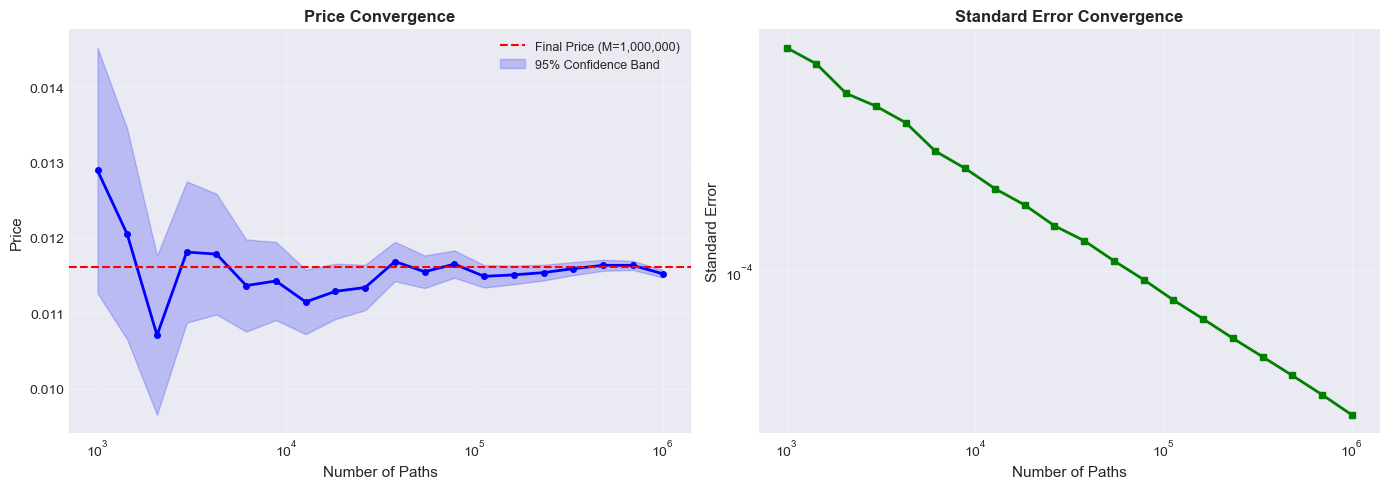


Convergence Statistics:
  Initial Price (M=1,000): $0.012895 ± $0.000831
  Final Price (M=1,000,000): $0.011525 ± $0.000026
  Price Change: $-0.001370
  Relative Error Reduction: 32.50x


In [26]:
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price convergence
axes[0].plot(path_counts, prices_conv, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].axhline(y=price, color='r', linestyle='--', linewidth=1.5, 
                label=f'Final Price (M={params.M:,})')
axes[0].fill_between(path_counts, 
                     prices_conv - 1.96*std_errors_conv,
                     prices_conv + 1.96*std_errors_conv,
                     alpha=0.2, color='blue', label='95% Confidence Band')
axes[0].set_xlabel('Number of Paths', fontsize=11)
axes[0].set_ylabel('Price', fontsize=11)
axes[0].set_title('Price Convergence', fontsize=12, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=9)

# Standard error convergence
axes[1].plot(path_counts, std_errors_conv, 'g-', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Number of Paths', fontsize=11)
axes[1].set_ylabel('Standard Error', fontsize=11)
axes[1].set_title('Standard Error Convergence', fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print convergence statistics
print(f"\nConvergence Statistics:")
print(f"  Initial Price (M={path_counts[0]:,}): ${prices_conv[0]:.6f} ± ${std_errors_conv[0]:.6f}")
print(f"  Final Price (M={path_counts[-1]:,}): ${prices_conv[-1]:.6f} ± ${std_errors_conv[-1]:.6f}")
print(f"  Price Change: ${prices_conv[-1] - prices_conv[0]:.6f}")
print(f"  Relative Error Reduction: {(std_errors_conv[0]/std_errors_conv[-1]):.2f}x")


## Distribution Analysis

Visualize the distribution of key simulation outputs.


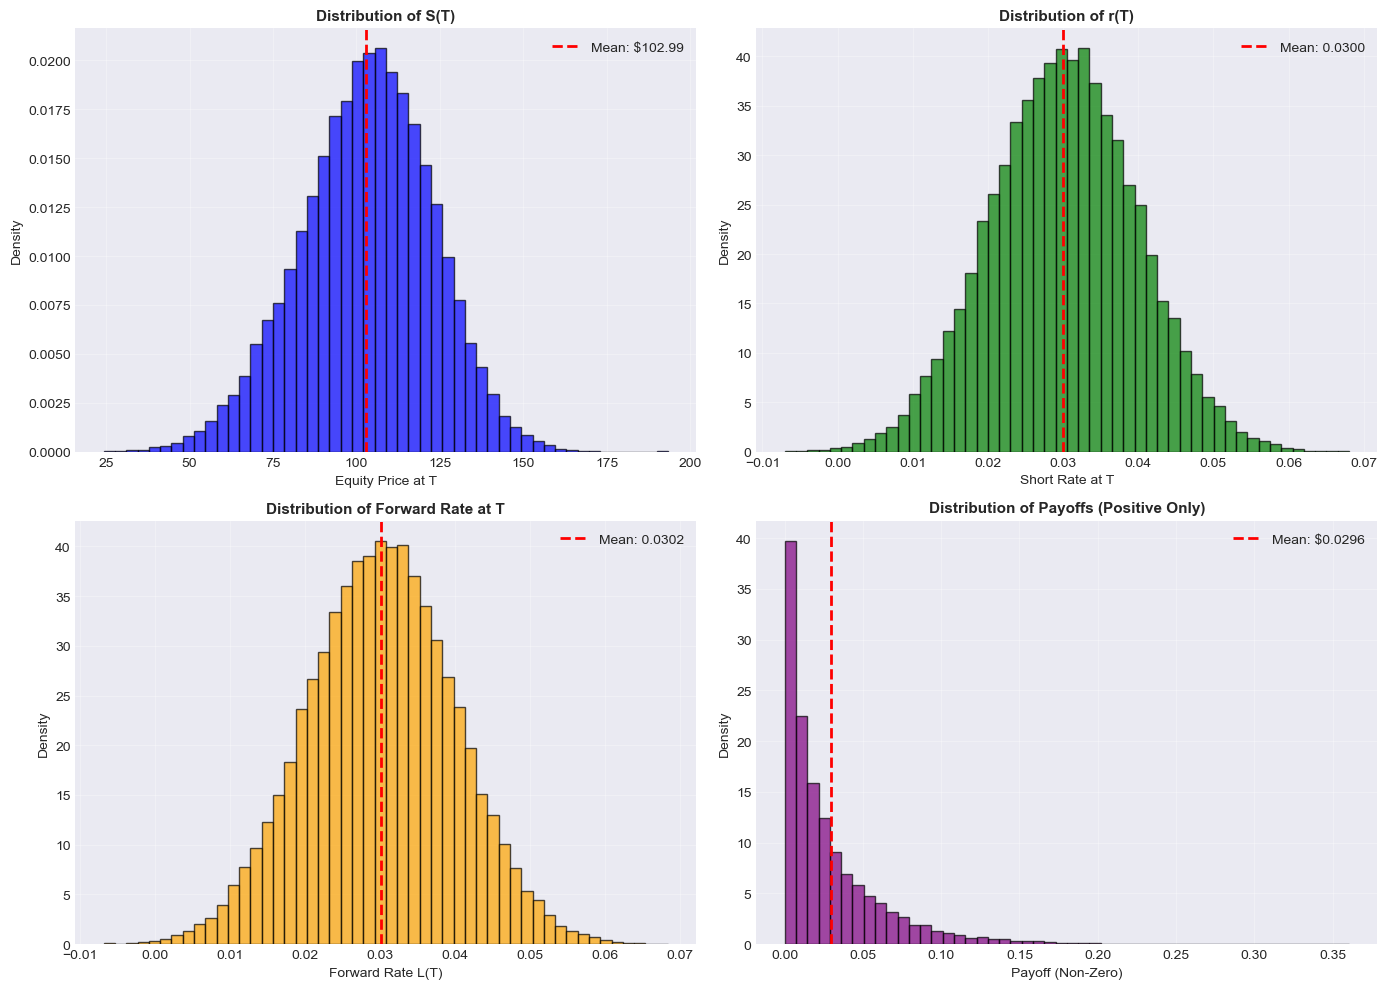


Distribution Statistics:
  S(T): Mean=$102.99, Std=$19.85, Min=$24.28, Max=$193.30
  r(T): Mean=0.0300, Std=0.0098, Min=-0.0070, Max=0.0680
  L(T): Mean=0.0302, Std=0.0098
  Payoff (non-zero): Mean=$0.0296, Std=$0.0349, Max=$0.3605


In [23]:
# Re-run simulation for distribution plots (using final parameters)
S_T_plot, r_T_plot, discount_plot = monte_carlo_simulation(params)
L_T_plot, L_0_plot = calculate_forward_rate(
    r_T_plot, params.T, params.Delta, 
    params.a, params.sigma_r, params.r0
)

# Calculate payoff components for visualization
equity_term_plot = params.k - (S_T_plot / params.S0)
rate_term_plot = (L_T_plot / L_0_plot) - params.k_prime
payoff_plot = params.N * np.maximum(0, equity_term_plot * rate_term_plot)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity distribution at maturity
axes[0, 0].hist(S_T_plot, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(np.mean(S_T_plot), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: ${np.mean(S_T_plot):.2f}')
axes[0, 0].set_xlabel('Equity Price at T', fontsize=10)
axes[0, 0].set_ylabel('Density', fontsize=10)
axes[0, 0].set_title('Distribution of S(T)', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Interest rate distribution at maturity
axes[0, 1].hist(r_T_plot, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(np.mean(r_T_plot), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(r_T_plot):.4f}')
axes[0, 1].set_xlabel('Short Rate at T', fontsize=10)
axes[0, 1].set_ylabel('Density', fontsize=10)
axes[0, 1].set_title('Distribution of r(T)', fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Forward rate distribution
axes[1, 0].hist(L_T_plot, bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(np.mean(L_T_plot), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(L_T_plot):.4f}')
axes[1, 0].set_xlabel('Forward Rate L(T)', fontsize=10)
axes[1, 0].set_ylabel('Density', fontsize=10)
axes[1, 0].set_title('Distribution of Forward Rate at T', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Payoff distribution (non-zero payoffs only)
non_zero_payoffs = payoff_plot[payoff_plot > 0]
axes[1, 1].hist(non_zero_payoffs, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
if len(non_zero_payoffs) > 0:
    axes[1, 1].axvline(np.mean(non_zero_payoffs), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: ${np.mean(non_zero_payoffs):.4f}')
axes[1, 1].set_xlabel('Payoff (Non-Zero)', fontsize=10)
axes[1, 1].set_ylabel('Density', fontsize=10)
axes[1, 1].set_title(f'Distribution of Payoffs (Positive Only)', fontsize=11, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDistribution Statistics:")
print(f"  S(T): Mean=${np.mean(S_T_plot):.2f}, Std=${np.std(S_T_plot):.2f}, "
      f"Min=${np.min(S_T_plot):.2f}, Max=${np.max(S_T_plot):.2f}")
print(f"  r(T): Mean={np.mean(r_T_plot):.4f}, Std={np.std(r_T_plot):.4f}, "
      f"Min={np.min(r_T_plot):.4f}, Max={np.max(r_T_plot):.4f}")
print(f"  L(T): Mean={np.mean(L_T_plot):.4f}, Std={np.std(L_T_plot):.4f}")
if len(non_zero_payoffs) > 0:
    print(f"  Payoff (non-zero): Mean=${np.mean(non_zero_payoffs):.4f}, "
          f"Std=${np.std(non_zero_payoffs):.4f}, Max=${np.max(non_zero_payoffs):.4f}")


## Model Validation

### Correlation Matrix Verification

Verify that the correlation matrix is positive definite and properly decomposed.


In [24]:
# Verify correlation matrix
corr_matrix = params.get_correlation_matrix()
L_chol = params.get_cholesky()

print("Correlation Matrix:")
print(corr_matrix)
print(f"\nCholesky Decomposition:")
print(L_chol)
print(f"\nVerification (L @ L.T should equal correlation matrix):")
print(L_chol @ L_chol.T)
print(f"\nIs positive definite: {np.all(np.linalg.eigvals(corr_matrix) > 0)}")

# Verify correlation structure in simulated data
# Generate a sample of correlated random numbers
sample_size = 100000
dW_sample = np.random.normal(0, 1, size=(sample_size, 3))
dW_corr_sample = dW_sample @ L_chol.T

# Calculate empirical correlations
empirical_corr = np.corrcoef(dW_corr_sample.T)
print(f"\nEmpirical Correlations from Simulation:")
print(empirical_corr)
print(f"\nTarget vs Empirical:")
print(f"  ρ(S,v): Target={params.rho_Sv:.3f}, Empirical={empirical_corr[0,1]:.3f}")
print(f"  ρ(S,r): Target={params.rho_Sr:.3f}, Empirical={empirical_corr[0,2]:.3f}")
print(f"  ρ(v,r): Target={params.rho_vr:.3f}, Empirical={empirical_corr[1,2]:.3f}")


Correlation Matrix:
[[ 1.  -0.7  0.3]
 [-0.7  1.   0. ]
 [ 0.3  0.   1. ]]

Cholesky Decomposition:
[[ 1.          0.          0.        ]
 [-0.7         0.71414284  0.        ]
 [ 0.3         0.29405882  0.90748521]]

Verification (L @ L.T should equal correlation matrix):
[[ 1.00000000e+00 -7.00000000e-01  3.00000000e-01]
 [-7.00000000e-01  1.00000000e+00 -1.08857439e-17]
 [ 3.00000000e-01 -1.08857439e-17  1.00000000e+00]]

Is positive definite: True

Empirical Correlations from Simulation:
[[ 1.         -0.70149464  0.30408489]
 [-0.70149464  1.         -0.00328437]
 [ 0.30408489 -0.00328437  1.        ]]

Target vs Empirical:
  ρ(S,v): Target=-0.700, Empirical=-0.701
  ρ(S,r): Target=0.300, Empirical=0.304
  ρ(v,r): Target=0.000, Empirical=-0.003


## Summary

This notebook implements a professional Monte Carlo pricing engine for a hybrid equity-rate derivative using:

1. **Heston Stochastic Volatility Model** for equity with Full Truncation scheme
2. **Hull-White One-Factor Model** for interest rates with closed-form bond pricing
3. **Vectorized NumPy implementation** for efficient computation
4. **Correlated Brownian motions** via Cholesky decomposition
5. **Convergence analysis** to validate Monte Carlo results

The implementation is production-ready and can be extended for:
- More complex payoff structures
- Additional risk factors
- Greeks calculation (via finite differences or pathwise methods)
- Variance reduction techniques (antithetic variates, control variates)
